In [31]:
import numpy as np
import pandas as pd
from pathlib import Path
import os
import matplotlib.pyplot as plt
import random

In [2]:
path_saves = Path('./../saves/ratings')

nat_ref_min = 0.6  # minimum score for ref for it to be classed as success
avg_nat_ref_min = 0.8  # average success score for person's results to be used

In [3]:
def question_bank(question):
    if question[:3] == 'sim':
        return '-'
    elif question[:3] == 'nat':
        return question[4]
    return 'Error'

In [18]:
df_results = pd.DataFrame()

# read all csv results files and create dataframe
for filename in os.listdir(path_saves):
    if filename.endswith(".csv"):
        path_file = path_saves / filename
        
        df_file = pd.read_csv(path_file)
        df_file = df_file.melt(id_vars=['file_keys'])
        
        df_results = pd.concat([df_results, df_file], ignore_index=True)
df_results

# rename columns and unpivot to have each row with a single question answer
df_results.rename(columns={'variable':'question'}, inplace=True)

# add info about question. Model, and what question bank it came from, eg. t=tricky, a=alexia (only for nat)
df_results['question_type'] = df_results['question'].str[:3]
df_results['model'] = df_results.question.str[-3:]
is_nat = df_results['question_type'] == 'nat'
df_results['question_bank'] = df_results.question.apply(question_bank)
df_results['ref_above_min'] = df_results['value'].apply(lambda x: True if x > nat_ref_min else False)

In [21]:
df_results_nat_ref = df_results[(df_results['question_type'] == 'nat') * (df_results['model']=='ref')]
avg_nat_ref = df_results_nat_ref.groupby('file_keys')['ref_above_min'].mean()

nat_passed = avg_nat_ref[avg_nat_ref > avg_nat_ref_min].index
nat_passed

Index(['1BFfnECsLUhZqcFGjrUQHk5kSABZpseX', '1tmTJpGcJfaLkvFvtnKMzzSdwyPWx1fW',
       '6sLzGpWn9zQ2uUZlvQr4IlVFLir3wmiZ', 'A5SkXxvfyTfJOQBtfMNdxUqiSLDy1xaS',
       'BrtiHoQEoruVr7g1qWVWaaM2LvyAN2H5', 'CbC9VkpTpVGvLrCSOvBkqp2Om3NG0o75',
       'CeKbIBOSc4Ji0TBoL47fWsHnnLygpody', 'GGWnoCon0cq5EOmxYSE7TZFwXLiikndg',
       'H0xOvkbVhoZue2swWhfkeEfd1xYyppMH', 'H6wO1Mvv53fK5yILaqFvOm47LiimFzcA',
       'NJs0lUiB1mW1CdMJKkoOXMp6XEZAS326', 'Q9LIlIpbAJrX6KBhzxS9IHrl34f8Rkux',
       'SwfV7dNBLePET3UQbp3B09q1CzNa7zgy', 'V0oLiC4eMyIyd5gt2YolP1cJOQIY1JPF',
       'VgPkOOBqa6Bzh5aB4X2NA0cFIOsddDCN', 'Z1iw7lWKMn0YRHwJ64NHXraEz1sP8KCH',
       'a2ODigvWDf95pB88Pxobk4Jep2yzlt7r', 'd0Im5RvDWkObfKAmlBqG6hWH3AVW3WM5',
       'iJHi6hvLu9fzNwF2Fq7eMtGt2i3XJBbV', 'igynDKazRuUU8VTQbgOXd419sJOjEMRv',
       'nYUWlxNpAxb7GAE7fJDb8HXUQhliY1Zd', 'pmvbXERWSuiBuCwgYNcD9E3mP3QZ7S6l',
       'sj1HtadWHCMyeaRNF3PeciL3gfMFoV70', 'uv8SoK0damKXWcO44cg890eH9NiuxECL',
       'xhxkQwnbt0QrrD5N55YWekCDQq20uDYj'],
      dt

In [41]:
results_sim = {'ref': None, 'mel': None, 'v09': None}
results_nat = {'ref': None, 'mel': None, 'v08': None, 'v09': None, 'v10': None}
sim_models = ['ref', 'mel', 'v09']
nat_models = ['ref', 'mel', 'v08', 'v09', 'v10']

for model in nat_models:
    results_nat[model] = np.array(df_results[(df_results['question_type'] == 'nat') * (df_results['model'] == model) * (df_results['file_keys'].isin(nat_passed))].value.tolist())


for model in sim_models:
    results_sim[model] = np.array(df_results[(df_results['question_type'] == 'sim') * (df_results['model'] == model)].value.tolist())

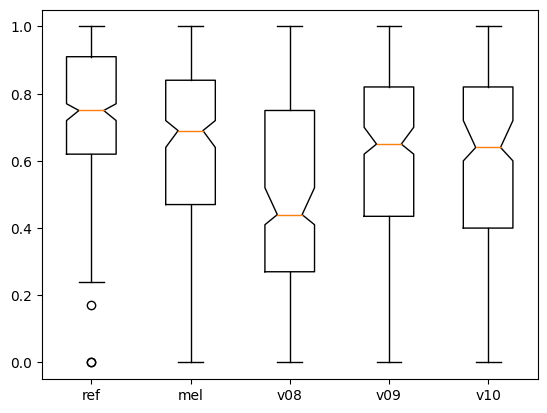

In [23]:
values = list(results_nat.values())
labels = list(results_nat.keys())

# Create a boxplot
plt.boxplot(values, labels=labels, notch=True, bootstrap=5000)
plt.show()

Now caluclate the mean result with confidence interval

In [66]:
nat_results_mean = {}
nb_bootstrap = 10000

for model in results_nat:
    results = results_nat[model]
    N = len(results)
    nat_results_mean[model] = {}
    nat_results_mean[model]['mean'] = results.mean()    
    
    mean_list = []
    for n in range(nb_bootstrap):
        random_sample = np.random.choice(results, size=N, replace=True)
        mean_list.append(random_sample.mean())
    mean_list.sort()
    
    lower_index = int(0.025 * nb_bootstrap)
    upper_index = int(0.975 * nb_bootstrap)
    nat_results_mean[model]['lower'] = mean_list[lower_index]
    nat_results_mean[model]['upper'] = mean_list[upper_index]

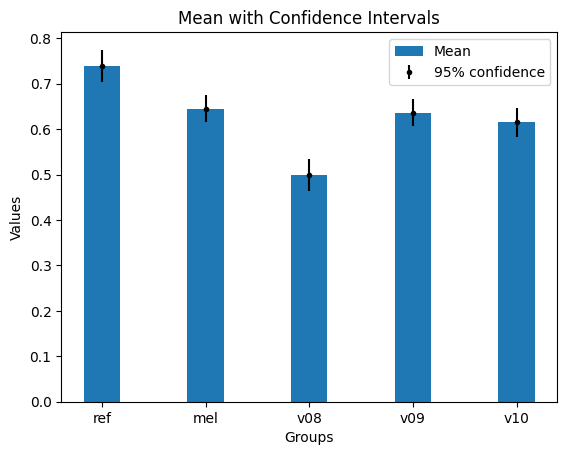

In [67]:
import matplotlib.pyplot as plt

# Sample data
means = []
lower_bounds = []
upper_bounds = []
for model in nat_results_mean:
    means.append(nat_results_mean[model]['mean'])
    lower_bounds.append(nat_results_mean[model]['lower'])
    upper_bounds.append(nat_results_mean[model]['upper'])

# Create a figure and axis
fig, ax = plt.subplots()

bar_width = 0.35

# Plot means with error bars (confidence intervals)
ax.bar(nat_results_mean.keys(), means, bar_width, label='Mean')
ax.errorbar(nat_results_mean.keys(), means, yerr=[means[i] - lower_bounds[i] for i in range(len(means))], fmt='.', label='95% confidence', color='black')


# Add a legend
ax.legend()

# Add labels and title
ax.set_xlabel('Groups')
ax.set_ylabel('Values')
ax.set_title('Mean with Confidence Intervals')

# Show the plot
plt.show()


In [68]:
nat_results_mean

{'ref': {'mean': 0.7390370370370372,
  'lower': 0.7034074074074074,
  'upper': 0.7742962962962961},
 'mel': {'mean': 0.6444649446494464,
  'lower': 0.6145756457564576,
  'upper': 0.6742435424354244},
 'v08': {'mean': 0.49800738007380074,
  'lower': 0.4627675276752768,
  'upper': 0.5321033210332103},
 'v09': {'mean': 0.6360147601476015,
  'lower': 0.6068634686346864,
  'upper': 0.6661992619926199},
 'v10': {'mean': 0.6147232472324722,
  'lower': 0.5835055350553505,
  'upper': 0.6455719557195573}}